In [1]:
from category_encoders import TargetEncoder as TE
import pandas as pd
from sklearn.datasets import load_boston
#-----------------

import syntheticFunctions as test_func
# -------------------START target packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# -------------------END target packages 

# -------------------START Bortorch packages 
import torch
import os
import math
import torch.nn.functional as F
import random
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import PosteriorMean
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.models import HeteroskedasticSingleTaskGP
from botorch.models import SingleTaskGP
from matplotlib import cm, ticker, colors
from scipy.optimize import rosen
from mpl_toolkits.mplot3d import Axes3D
from random import choice

# from TargetEncoderClass import TargetEncoder
from initDesignDomain import initBO
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.unicode_minus']=False
print('Libraries imported')
# -------------------END Bortorch packages 

# -------------------START
import syntheticFunctions
# -------------------END  


Libraries imported


In [3]:
# C[0] is number of category1, len(C) is the number of category
f = test_func.func2C
C = [3, 5]
bounds = [
    {'name': 'h1', 'type': 'categorical', 'domain': (0, 1, 2)},
    {'name': 'h2', 'type': 'categorical', 'domain': (0, 1, 2, 3, 4)},
    {'name': 'x1', 'type': 'continuous', 'domain': (-1, 1)},
    {'name': 'x2', 'type': 'continuous', 'domain': (-1, 1)}]
# generate inital samples
init_N = 24
ini_obj = initBO(f, init_N, bounds, C)
data, y = ini_obj.initialise(seed=24)

Using existing init data for seed 24


In [4]:
# fig = plt.figure(figsize=[4, 2])
# plt.hist(y)
# plt.xlabel('value')
# plt.ylabel('count')

In [5]:
X = pd.DataFrame(data)
target_encoder = TE(cols=[0, 1]).fit(data, y.numpy().reshape(-1))
z = target_encoder.transform(data)

D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [6]:
z

,0,1,2,3
0,0.805844,0.464988,0.920035,0.399024
1,0.805844,0.464988,0.999735,-0.559865
2,0.363991,0.351312,-0.277887,0.479682
3,2.158045,2.803958,0.992911,-0.367306
4,0.805844,2.803958,-0.726911,-0.232040
5,0.363991,0.351312,-0.358961,-0.267170
6,0.805844,1.345091,0.419303,0.800285
7,2.158045,0.464988,0.068231,-0.505412
8,0.805844,0.351312,0.343613,0.123458
9,2.158045,1.345091,0.085120,0.786895


In [7]:
# # print all the columns after encoded
# for i in range(X.shape[1]):
#     print(enc_X[i].value_counts(), '\n')
# # enc_X[0].value_counts()

In [8]:
def get_can_h_x_y(index):
    # design_data: ndarray , design_y: tensor
    can_h_x = design_data[index, :]
    can_y = design_y[index]
    return can_h_x, can_yn

In [9]:
def get_design_domain(target_encoder):
    design_z = target_encoder.transform(design_data)
    return torch.from_numpy(np.array(design_z))

In [10]:
design_N = 5000
design_obj = initBO(f, design_N, bounds, C)
design_data, design_y = design_obj.initialise(seed=55)

Using existing init data for seed 55


In [11]:
30 * pow(0.975, 100)

2.3855186958549424

In [12]:
num_iter = 50
maxindex_list = []
max_list = []
record_h = pd.DataFrame(np.array(['null','null']).reshape(1, 2))

In [13]:
for i in range(num_iter):
    print("iteration: ", i)
    gp = SingleTaskGP(torch.from_numpy(np.array(z)), y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
        # the design_domain's encode should be updated
    design_z = get_design_domain(target_encoder)
    pred_design = gp.posterior(design_z).mean.detach().numpy().reshape(-1)
    beta_decay= 100 * 0.98 ** (i)
#     UCB = UpperConfidenceBound(model=gp, beta=beta_decay, maximize=False)    
    UCB = UpperConfidenceBound(model=gp, beta=beta_decay)

    acq_value = UCB(design_z.unsqueeze(-2))
    max_index = torch.argmax(acq_value, dim=-1).tolist()
    maxindex_list.append(max_index)
    # candidate 
    candidate_h_x = design_data[max_index]
    candidate_z = design_z[max_index].unsqueeze(-2)
    candidate_y = design_y[max_index].unsqueeze(0)
    
    data = np.vstack((data, candidate_h_x))
    y = torch.vstack((y, candidate_y))
    target_encoder = TE(cols=[0, 1]).fit(data, y.numpy().reshape(-1))
    z = target_encoder.transform(data)
    max_list.append(candidate_y)


iteration:  0


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  1
iteration:  2


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  3
iteration:  4


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  5
iteration:  6


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  7
iteration:  8


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  9
iteration:  10


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  11
iteration:  12


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  13


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  14
iteration:  15
iteration:  16


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  17
iteration: 

D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


 18
iteration:  19


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  20
iteration:  21


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  22
iteration:  23


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  24


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  25


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  26
iteration:  27
iteration:  28


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  29
iteration:  30


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  31
iteration: 

D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


 32
iteration:  33


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  34
iteration:  35


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  36
iteration:  37
iteration: 

D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


 38
iteration:  39


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  40


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  41


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  42
iteration: 

D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


 43
iteration:  44
iteration:  45


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  46
iteration:  47


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


iteration:  48
iteration:  49


D:\Tools\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [14]:
y

tensor([[ 0.2694],
        [ 0.7945],
        [ 0.3182],
        [ 7.4099],
        [ 1.7003],
        [ 0.6381],
        [ 1.1482],
        [ 0.5975],
        [ 0.2934],
        [ 1.5955],
        [ 0.1662],
        [ 0.0998],
        [ 3.2386],
        [ 2.2525],
        [ 0.7284],
        [ 0.7803],
        [ 0.0990],
        [ 0.4627],
        [ 0.3017],
        [ 0.3487],
        [ 0.4092],
        [ 5.8176],
        [ 0.0250],
        [ 0.0775],
        [ 7.4347],
        [ 1.5307],
        [11.9344],
        [ 3.7451],
        [ 1.3906],
        [ 8.8525],
        [ 2.3985],
        [ 9.8142],
        [ 0.5134],
        [ 9.8656],
        [ 9.5124],
        [ 5.8575],
        [ 8.9864],
        [ 0.6871],
        [ 1.0548],
        [ 0.2505],
        [ 1.7575],
        [ 0.2543],
        [ 3.8486],
        [ 2.1610],
        [15.0847],
        [16.0106],
        [ 3.7910],
        [ 8.9236],
        [12.3975],
        [10.3540],
        [18.2717],
        [ 8.7649],
        [ 8.

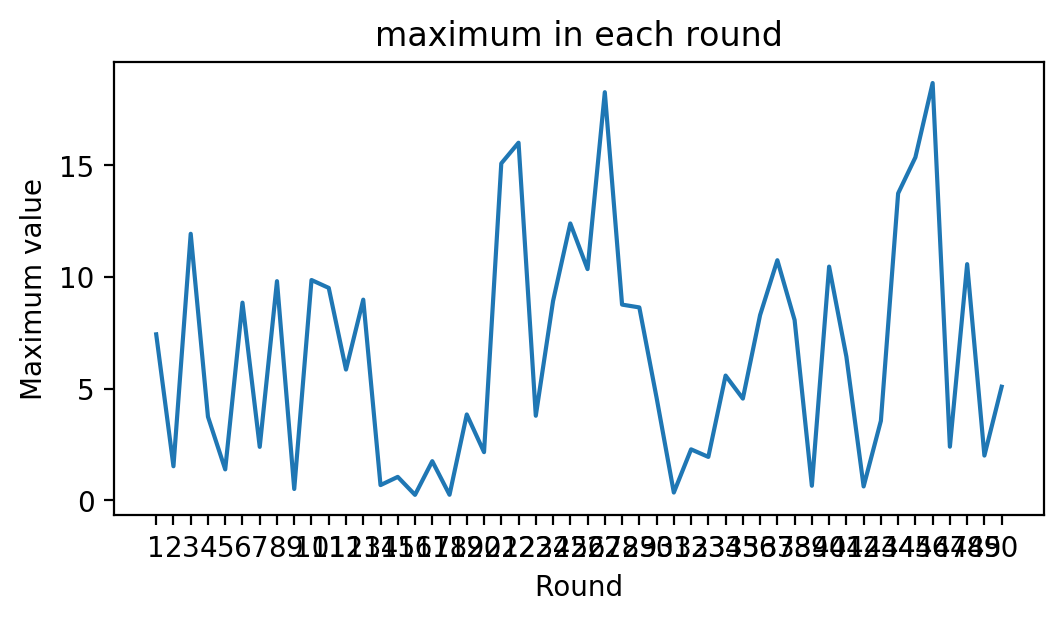

In [15]:
fig1 = plt.figure(figsize=(6,3))
x_iter = np.arange(1, z.shape[0] - init_N + 1).astype(dtype=np.str)
plt.xlabel('Round')
plt.ylabel('Maximum value')
plt.title('maximum in each round')
plt.plot(x_iter, max_list)
# plt.savefig('D:\\GP_BO\\'+ 'maximum in each round' '.pdf', dpi=600)

Text(0, 0.5, 'count')

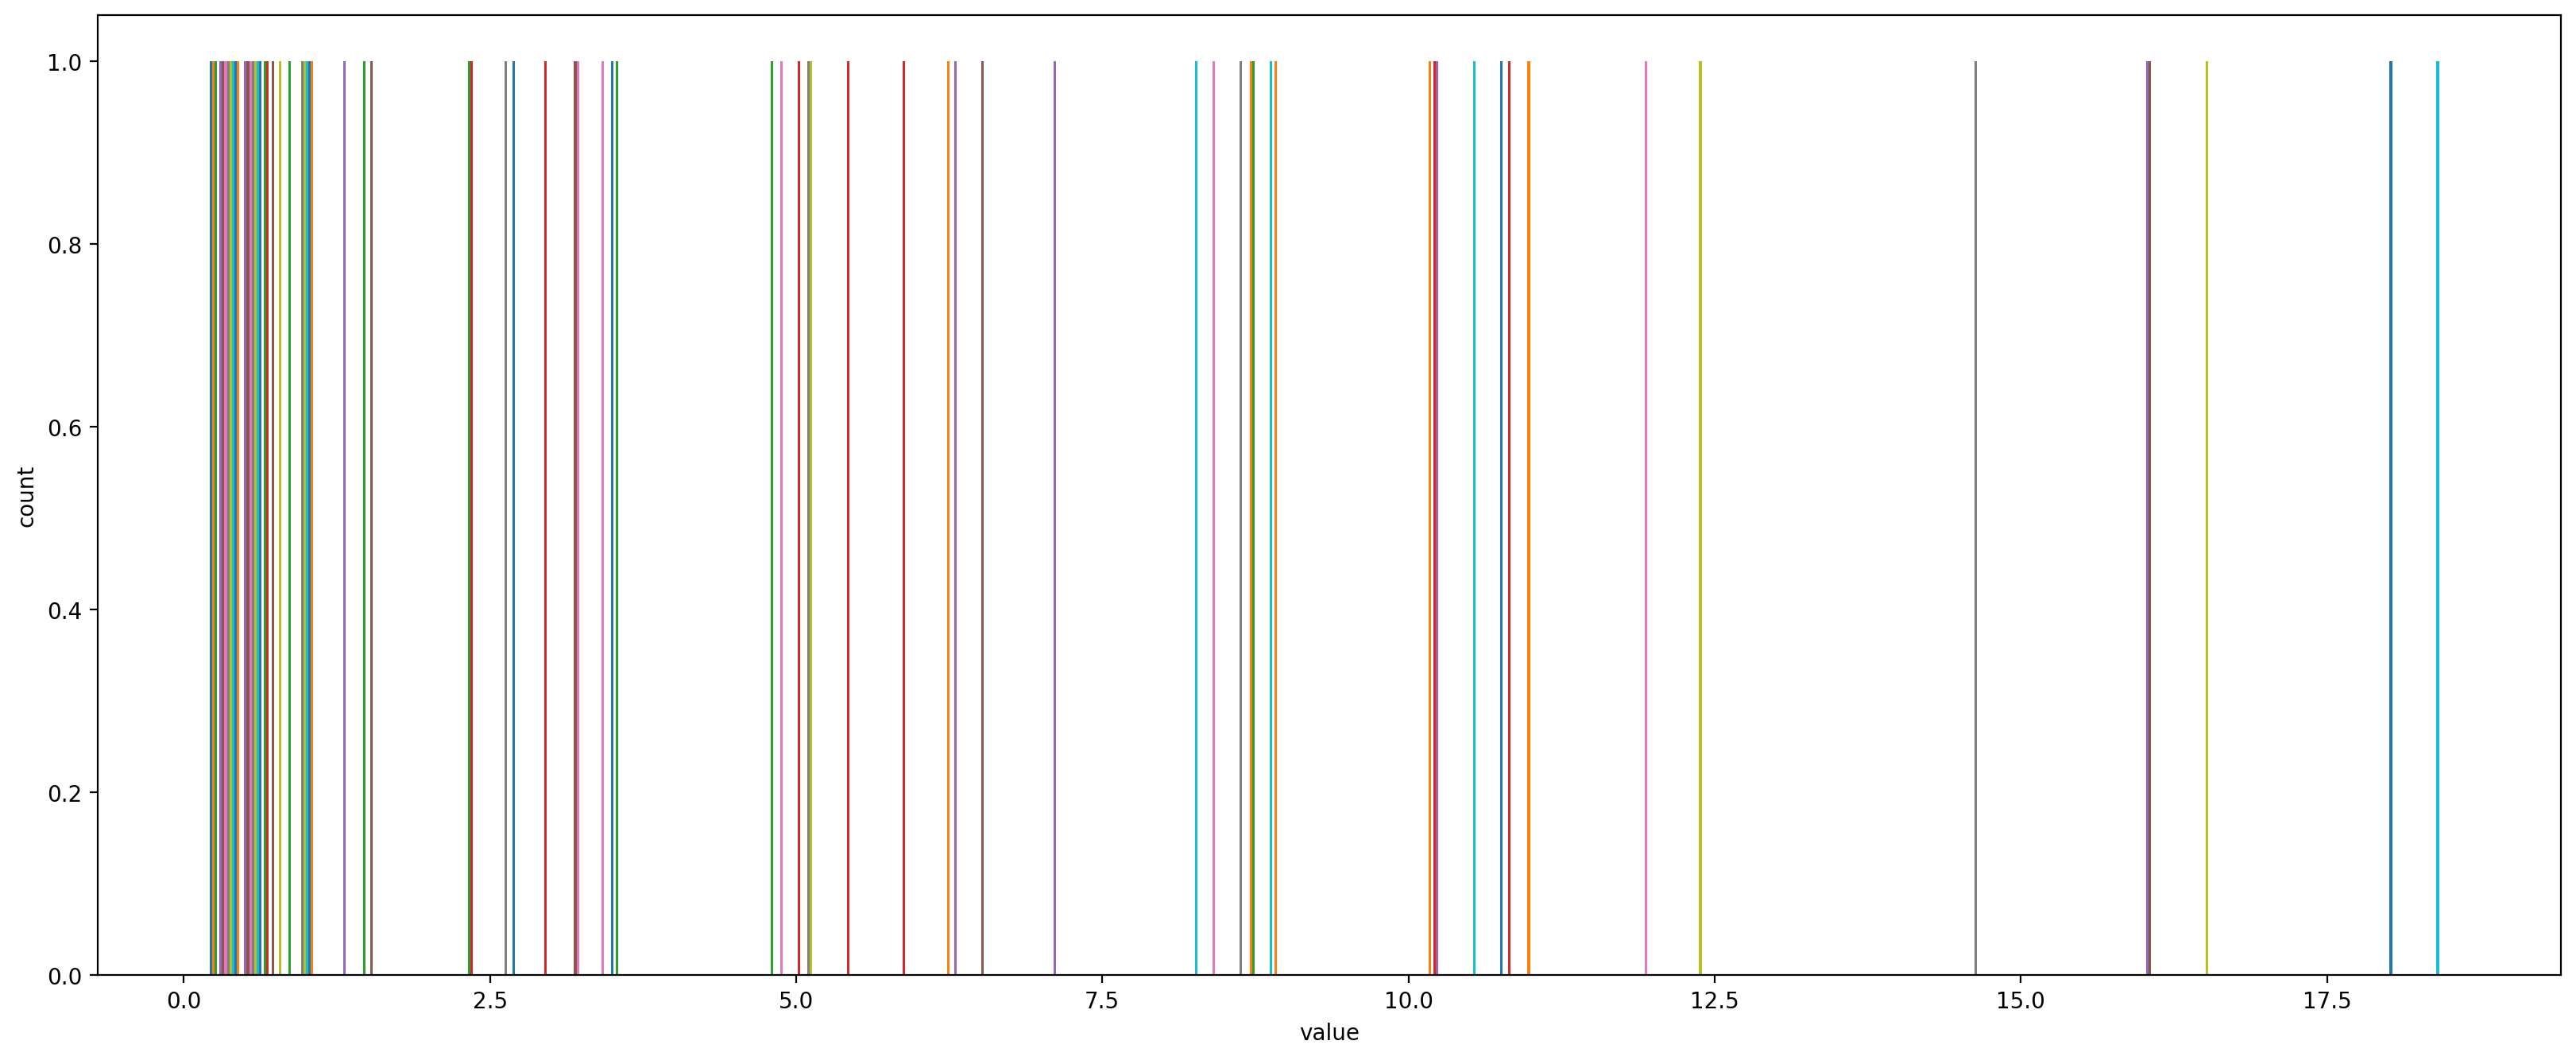

In [16]:
fig = plt.figure(figsize=[20, 8])
plt.hist(y)
plt.xlabel('value')
plt.ylabel('count')

In [21]:
print("design_y:",design_y.max(), "y.max:",y.max())

design_y: tensor(19.6227, dtype=torch.float64) y.max: tensor(18.6816, dtype=torch.float64)
